<a href="https://colab.research.google.com/github/Nick-Azzarano/Machine-Learning-Practice/blob/main/Spring2025/Final_Project/Azzarano_Nick_ML_Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Nick Azzarano
<br/>
CSCI 335
<br/>
Anton Selitskiy
<br/>
May 7, 2025

# CSCI-335 Final Project: Project 1 Fine-Tuning

**Introduction**


---


In this task you are asked to fine-tune a pretrained neural network for the task of classification of the bird species using PyTorch framework.
Fine-tuning is the process of adjusting a pre-trained model on a specific task, which involves using a pre- trained model on a large dataset (for example, ImageNet) and adapting it to a different dataset for a specific task. The final layer, responsible for classifying the output, is typically modified to match the number of classes in the target dataset. Moreover, during fine-tuning, the weights of the model are updated with a lower learning rate, and sometimes only the final layers are trained. This approach allows the model to generalize well to the specific data distribution of the target task while leveraging the knowledge gained from the pre-training on a larger dataset. The fine-tuned model is particularly effective when dealing with limited labeled data for the target task.


**Fine-tuning Procedure**


---


To fine-tune the model, consider using the light MobileNetV2 pre- trained model (or ResNet or other model), preserving its learned weights. Set the requires_grad_ attribute to False for the layers you do not plan to fine-tune. You may unfreeze last 1-3 layers and apply Global Average Pooling to the preserved features and add a fully connected layer with a softmax activation (which is built-in in the CrossEntropyLoss). Choose a learning rate not exceeding 0.40. Avoid setting too high the learning rate to prevent disrupting the learned features.

**Evaluation**


---


The evaluation of the fine-tuned model is performed on a separate validation set. You may use torch.utils.data.random_split The classification performance is measured using accuracy. The model is saved as 'birds_model.pt' after fine-tuning.

**Notes on Implementation**


---


The model is fine-tuned for 15 epochs or until it reaches an accuracy of 85%. The final accuracy is recorded along with the top-k accuracies.

You may improve the classifier using the following ideas:

1.   In the initial step, you can explore the dataset to understand its characteristics.
2.   You can add a fully connected layer, followed by Batch Normalization to avoid overfitting.
3.  Fine-tune with the desired number of output classes in the last fully connected layer, which you will modify.
4. Apply data augmentation techniques, such as Albumentations, to enhance the diversity of your data.
5. Experiment with various architectures and consider implementing a heavier model. Also, pay attention to the balance between precision and recall.
6. If your model does not converge, adjust the learning rate and experiment with different optimizers.


**Point Breakdown**
*   acc > 0.85 - 20 points
*   acc > 0.83 - 18 points
*   acc > 0.80 - 16 points
*   acc > 0.75 - 14 points
*   acc > 0.70 - 12 points








***Use folder train only. You may want to use Pandas for reading the gt.csv file***

Here are the directories structures:

*   00_test_img_gt
  * gt.csv (csv file with labeled classification for each image file)
*   00_test_img_input
  * test
      * images
  * train
      * images (directory containing the input data images)
      * gt.csv (csv file with labeled classification for each image file)





---



In [1]:
import pandas as pd
import numpy as np
import torch
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset, random_split
from PIL import Image
from torchvision.io import read_image
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

In [2]:
# Need to upload public_tests.zip each time you use this notebook
!unzip public_tests.zip

Streaming output truncated to the last 5000 lines.
  inflating: 00_test_img_input/test/images/0672.jpg  
  inflating: 00_test_img_input/test/images/2085.jpg  
  inflating: 00_test_img_input/test/images/0106.jpg  
  inflating: 00_test_img_input/test/images/1056.jpg  
  inflating: 00_test_img_input/test/images/1159.jpg  
  inflating: 00_test_img_input/test/images/0256.jpg  
  inflating: 00_test_img_input/test/images/2269.jpg  
  inflating: 00_test_img_input/test/images/0664.jpg  
  inflating: 00_test_img_input/test/images/1981.jpg  
  inflating: 00_test_img_input/test/images/0929.jpg  
  inflating: 00_test_img_input/test/images/1888.jpg  
  inflating: 00_test_img_input/test/images/0957.jpg  
  inflating: 00_test_img_input/test/images/0389.jpg  
  inflating: 00_test_img_input/test/images/0323.jpg  
  inflating: 00_test_img_input/test/images/0717.jpg  
  inflating: 00_test_img_input/test/images/0186.jpg  
  inflating: 00_test_img_input/test/images/0468.jpg  
  inflating: 00_test_img_input/

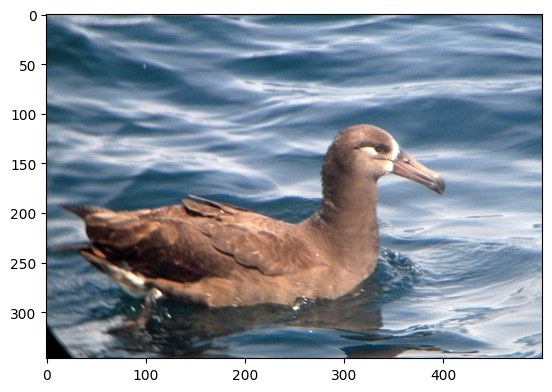

In [4]:
# Make sure the images are accessible
im = read_image('/content/00_test_img_input/train/images/0001.jpg')
plt.imshow(im.permute(1, 2, 0)/255)
# plt.imshow(im.permute(1, 2, 0)/255, cmap='gray')

In [5]:
im.shape

torch.Size([3, 347, 500])

In [6]:
import pathlib

In [7]:
# Custom Dataset Class
class My_Dataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.annotations = pd.read_csv(csv_file)
        self.annotations["class_id"] = self.annotations["class_id"].astype(int)
        self.path_to_data = pathlib.Path(root_dir)
        self.transform = transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):
        img_filename = str(self.annotations.iloc[index, 0])
        label = self.annotations.iloc[index, 1]

        img_path = self.path_to_data / img_filename
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image, label

In [8]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torchvision.transforms import ToPILImage

In [9]:
# Training transform and albumentation
class AlbumentationsTransform:
    def __init__(self):
        self.transform = A.Compose([
            A.Resize(224, 224),
            A.HorizontalFlip(p=0.5),
            A.RandomBrightnessContrast(p=0.2),
            A.Rotate(limit=15, p=0.3),
            A.Normalize(mean=(0.485, 0.456, 0.406),
                        std=(0.229, 0.224, 0.225)),
            ToTensorV2()
        ])

    def __call__(self, image):
        # Convert PIL to NumPy
        image = np.array(image)
        augmented = self.transform(image=image)
        return augmented['image']

In [10]:
train_transform = AlbumentationsTransform()

In [11]:
# Validation transform
val_transform = A.Compose([
    A.Resize(224, 224),
    A.Normalize(mean=(0.485, 0.456, 0.406),
                std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

In [12]:
dataset = My_Dataset(csv_file='/content/00_test_img_input/train/gt.csv', root_dir='/content/00_test_img_input/train/images', transform=None)

In [13]:
train_size = int(0.8 * len(dataset))  # 80% training, 20% validation
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

In [14]:
# After splitting
train_dataset.dataset.transform = train_transform
val_dataset.dataset.transform = val_transform

In [15]:
# Load pretrained ResNet model
resnet = models.resnet18(pretrained=True)  # or models.resnet50(pretrained=True)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 221MB/s]


In [16]:
# Freezing all the layers first
for param in resnet.parameters():
    param.requires_grad = False

In [17]:
# Specify that there are 50 classes
resnet.fc = nn.Linear(resnet.fc.in_features, out_features=50)

In [19]:
# Unfreeze last few layers to allow for more tuning
for name, param in resnet.named_parameters():
    if "layer4" in name:
        param.requires_grad = True

In [21]:
# # A custom classifier for the final layers of ResNet
# class CustomClassifier(nn.Module):
#     def __init__(self, in_features, num_classes):
#         super().__init__()
#         self.bn = nn.BatchNorm1d(in_features)
#         self.fc = nn.Linear(in_features, num_classes)

#     def forward(self, x):
#         x = self.bn(x)
#         x = self.fc(x)
#         return x

# resnet.fc = CustomClassifier(resnet.fc.in_features, num_classes)

In [22]:
# num_classes = 50  # There are 50 classifications in the data
# resnet.fc = nn.Sequential(
#     nn.BatchNorm1d(resnet.fc.in_features),  # optional
#     nn.Linear(resnet.fc.in_features, num_classes)
# )

In [23]:
# Move the model to the GPU if I can
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [24]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet.parameters(), lr=0.001)

In [25]:
# Create data loaders
train_loader = DataLoader(
    train_dataset,
    batch_size=64,
    shuffle=True, # Always shuffle training data
    pin_memory=True if torch.cuda.is_available() else False
)


val_loader = DataLoader(
    val_dataset,
    batch_size=64,
    shuffle=False, # No shuffle for validation
    pin_memory=True if torch.cuda.is_available() else False
)

In [26]:
# Top 10 Accuracies function
def top_k_accuracy(output, target, k=10):
    """Computes top-k accuracy for classification"""
    with torch.no_grad():
        topk = torch.topk(output, k=k, dim=1).indices
        match = topk.eq(target.view(-1, 1).expand_as(topk))
        correct_k = match.any(dim=1).float().sum().item()
        return correct_k / target.size(0)

In [27]:
import csv

In [28]:
# TRAINING FUNCTION
def train_one_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

In [29]:
# VALIDATION FUNCTION
def validate(model, dataloader, criterion, device, k=10):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    topk_correct = 0

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            topk_correct += top_k_accuracy(outputs, labels, k=k) * labels.size(0)

    epoch_loss = running_loss / total
    top1_acc = correct / total
    topk_acc = topk_correct / total
    return epoch_loss, top1_acc, topk_acc

In [30]:
# Train on 15 epochs, and evaluate as the model is trained
num_epochs = 15
best_acc = 0.0

# Create CSV file and header
log_path = "training_log.csv"
with open(log_path, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Epoch', 'Train Loss', 'Train Acc', 'Val Loss', 'Val Acc', 'Top-10 Acc'])


for epoch in range(num_epochs):
    train_loss, train_acc = train_one_epoch(resnet, train_loader, optimizer, criterion, device)
    val_loss, val_acc, val_topk = validate(resnet, val_loader, criterion, device, k=10)

    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    # print(f"  Val   Loss: {val_loss:.4f} | Val   Acc: {val_acc:.4f}")
    print(f"  Val Loss: {val_loss:.4f} | Top-1 Acc: {val_acc:.4f} | Top-10 Acc: {val_topk:.4f}")

    # Save best model
    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(resnet.state_dict(), "birds_model.pt")
        print(f"Saved model with val_acc = {val_acc:.4f}")

    # Save accuracy results to separate .csv file
    with open(log_path, mode='a', newline='') as file:
      writer = csv.writer(file)
      writer.writerow([epoch+1, train_loss, train_acc, val_loss, val_acc, val_topk])

    # Early stopping (optional)
    if val_acc >= 0.85:
        print("Reached target accuracy of 85%. Stopping training.")
        break

KeyError: 'You have to pass data to augmentations as named arguments, for example: aug(image=image)'

In [ ]:
log_df = pd.read_csv("training_log.csv")

In [ ]:
# Plotting the accuracy
plt.figure(figsize=(10, 6))
plt.plot(log_df['Epoch'], log_df['Train Acc'], label='Train Accuracy', marker='o')
plt.plot(log_df['Epoch'], log_df['Val Acc'], label='Validation Accuracy', marker='o')
plt.plot(log_df['Epoch'], log_df['Top-10 Acc'], label='Top-10 Accuracy', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Over Time')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# Plotting the loss
plt.figure(figsize=(10, 6))
plt.plot(log_df['Epoch'], log_df['Train Loss'], label='Train Loss', marker='o')
plt.plot(log_df['Epoch'], log_df['Val Loss'], label='Validation Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Over Time')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()